## Understanding the Datasets

### Train vs. Test
In this competition, you’ll gain access to two datasets that are samples of past subscriptions of a video streaming platform that contain information about the customer, the customers streaming preferences, and their activity in the subscription thus far. One dataset is titled `train.csv` and the other is titled `test.csv`.

`train.csv` contains 70% of the overall sample (243,787 subscriptions to be exact) and importantly, will reveal whether or not the subscription was continued into the next month (the “ground truth”).

The `test.csv` dataset contains the exact same information about the remaining segment of the overall sample (104,480 subscriptions to be exact), but does not disclose the “ground truth” for each subscription. It’s your job to predict this outcome!

Using the patterns you find in the `train.csv` data, predict whether the subscriptions in `test.csv` will be continued for another month, or not.

### Dataset descriptions
Both `train.csv` and `test.csv` contain one row for each unique subscription. For each subscription, a single observation (`CustomerID`) is included during which the subscription was active. 

In addition to this identifier column, the `train.csv` dataset also contains the target label for the task, a binary column `Churn`.

Besides that column, both datasets have an identical set of features that can be used to train your model to make predictions. Below you can see descriptions of each feature. Familiarize yourself with them so that you can harness them most effectively for this machine learning task!

In [1]:
import pandas as pd
data_descriptions = pd.read_csv('data_descriptions.csv')
pd.set_option('display.max_colwidth', None)
data_descriptions

,Column_name,Column_type,Data_type,Description
0,AccountAge,Feature,integer,The age of the user's account in months.
1,MonthlyCharges,Feature,float,The amount charged to the user on a monthly basis.
2,TotalCharges,Feature,float,The total charges incurred by the user over the account's lifetime.
3,SubscriptionType,Feature,object,"The type of subscription chosen by the user (Basic, Standard, or Premium)."
4,PaymentMethod,Feature,string,The method of payment used by the user.
5,PaperlessBilling,Feature,string,Indicates whether the user has opted for paperless billing (Yes or No).
6,ContentType,Feature,string,"The type of content preferred by the user (Movies, TV Shows, or Both)."
7,MultiDeviceAccess,Feature,string,Indicates whether the user has access to the service on multiple devices (Yes or No).
8,DeviceRegistered,Feature,string,"The type of device registered by the user (TV, Mobile, Tablet, or Computer)."
9,ViewingHoursPerWeek,Feature,float,The number of hours the user spends watching content per week.


## How to Submit your Predictions to Coursera
Submission Format:

In this notebook you should follow the steps below to explore the data, train a model using the data in `train.csv`, and then score your model using the data in `test.csv`. Your final submission should be a dataframe (call it `prediction_df` with two columns and exactly 104,480 rows (plus a header row). The first column should be `CustomerID` so that we know which prediction belongs to which observation. The second column should be called `predicted_probability` and should be a numeric column representing the __likellihood that the subscription will churn__.

Your submission will show an error if you have extra columns (beyond `CustomerID` and `predicted_probability`) or extra rows. The order of the rows does not matter.

The naming convention of the dataframe and columns are critical for our autograding, so please make sure to use the exact naming conventions of `prediction_df` with column names `CustomerID` and `predicted_probability`!

To determine your final score, we will compare your `predicted_probability` predictions to the source of truth labels for the observations in `test.csv` and calculate the [ROC AUC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html). We choose this metric because we not only want to be able to predict which subscriptions will be retained, but also want a well-calibrated likelihood score that can be used to target interventions and support most accurately.

## Import Python Modules

First, import the primary modules that will be used in this project. Remember as this is an open-ended project please feel free to make use of any of your favorite libraries that you feel may be useful for this challenge. For example some of the following popular packages may be useful:

- pandas
- numpy
- Scipy
- Scikit-learn
- keras
- maplotlib
- seaborn
- etc, etc

In [2]:
# Import required packages

# Data packages
import pandas as pd
import numpy as np
print(np.__version__)

# Machine Learning / Classification packages
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

# Visualization Packages
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
try:
    from xgboost import XGBClassifier
except:
    !pip install -q xgboost
    from xgboost import XGBClassifier
    
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.under_sampling import RandomUnderSampler
except ImportError:
    try:
        import imblearn
    except ImportError:
        !pip install -q imblearn
    from imblearn.over_sampling import SMOTE
    from imblearn.under_sampling import RandomUnderSampler


    
random_state = 42

1.18.4


## Load the Data

Let's start by loading the dataset `train.csv` into a dataframe `train_df`, and `test.csv` into a dataframe `test_df` and display the shape of the dataframes.

In [3]:
train_df = pd.read_csv("train.csv")
print('train_df Shape:', train_df.shape)
train_df.head()

train_df Shape: (243787, 21)


,AccountAge,MonthlyCharges,TotalCharges,SubscriptionType,PaymentMethod,PaperlessBilling,ContentType,MultiDeviceAccess,DeviceRegistered,ViewingHoursPerWeek,...,ContentDownloadsPerMonth,GenrePreference,UserRating,SupportTicketsPerMonth,Gender,WatchlistSize,ParentalControl,SubtitlesEnabled,CustomerID,Churn
0,20,11.055215,221.104302,Premium,Mailed check,No,Both,No,Mobile,36.758104,...,10,Sci-Fi,2.176498,4,Male,3,No,No,CB6SXPNVZA,0
1,57,5.175208,294.986882,Basic,Credit card,Yes,Movies,No,Tablet,32.450568,...,18,Action,3.478632,8,Male,23,No,Yes,S7R2G87O09,0
2,73,12.106657,883.785952,Basic,Mailed check,Yes,Movies,No,Computer,7.395160,...,23,Fantasy,4.238824,6,Male,1,Yes,Yes,EASDC20BDT,0
3,32,7.263743,232.439774,Basic,Electronic check,No,TV Shows,No,Tablet,27.960389,...,30,Drama,4.276013,2,Male,24,Yes,Yes,NPF69NT69N,0
4,57,16.953078,966.325422,Premium,Electronic check,Yes,TV Shows,No,TV,20.083397,...,20,Comedy,3.616170,4,Female,0,No,No,4LGYPK7VOL,0


In [4]:
test_df = pd.read_csv("test.csv")
print('test_df Shape:', test_df.shape)
test_df.head()

test_df Shape: (104480, 20)


,AccountAge,MonthlyCharges,TotalCharges,SubscriptionType,PaymentMethod,PaperlessBilling,ContentType,MultiDeviceAccess,DeviceRegistered,ViewingHoursPerWeek,AverageViewingDuration,ContentDownloadsPerMonth,GenrePreference,UserRating,SupportTicketsPerMonth,Gender,WatchlistSize,ParentalControl,SubtitlesEnabled,CustomerID
0,38,17.869374,679.036195,Premium,Mailed check,No,TV Shows,No,TV,29.126308,122.274031,42,Comedy,3.522724,2,Male,23,No,No,O1W6BHP6RM
1,77,9.912854,763.289768,Basic,Electronic check,Yes,TV Shows,No,TV,36.873729,57.093319,43,Action,2.021545,2,Female,22,Yes,No,LFR4X92X8H
2,5,15.019011,75.095057,Standard,Bank transfer,No,TV Shows,Yes,Computer,7.601729,140.414001,14,Sci-Fi,4.806126,2,Female,22,No,Yes,QM5GBIYODA
3,88,15.357406,1351.451692,Standard,Electronic check,No,Both,Yes,Tablet,35.586430,177.002419,14,Comedy,4.943900,0,Female,23,Yes,Yes,D9RXTK2K9F
4,91,12.406033,1128.949004,Standard,Credit card,Yes,TV Shows,Yes,Tablet,23.503651,70.308376,6,Drama,2.846880,6,Female,0,No,No,ENTCCHR1LR


Check for missing value

In [5]:
print('train missing values check\n', train_df.isna().sum())
print('\ntest missing values check\n', test_df.isna().sum())

train missing values check
 AccountAge                  0
MonthlyCharges              0
TotalCharges                0
SubscriptionType            0
PaymentMethod               0
PaperlessBilling            0
ContentType                 0
MultiDeviceAccess           0
DeviceRegistered            0
ViewingHoursPerWeek         0
AverageViewingDuration      0
ContentDownloadsPerMonth    0
GenrePreference             0
UserRating                  0
SupportTicketsPerMonth      0
Gender                      0
WatchlistSize               0
ParentalControl             0
SubtitlesEnabled            0
CustomerID                  0
Churn                       0
dtype: int64

test missing values check
 AccountAge                  0
MonthlyCharges              0
TotalCharges                0
SubscriptionType            0
PaymentMethod               0
PaperlessBilling            0
ContentType                 0
MultiDeviceAccess           0
DeviceRegistered            0
ViewingHoursPerWeek         0
A

## Explore, Clean, Validate, and Visualize the Data (optional)

Feel free to explore, clean, validate, and visualize the data however you see fit for this competition to help determine or optimize your predictive model. Please note - the final autograding will only be on the accuracy of the `prediction_df` predictions.

Check for correlation

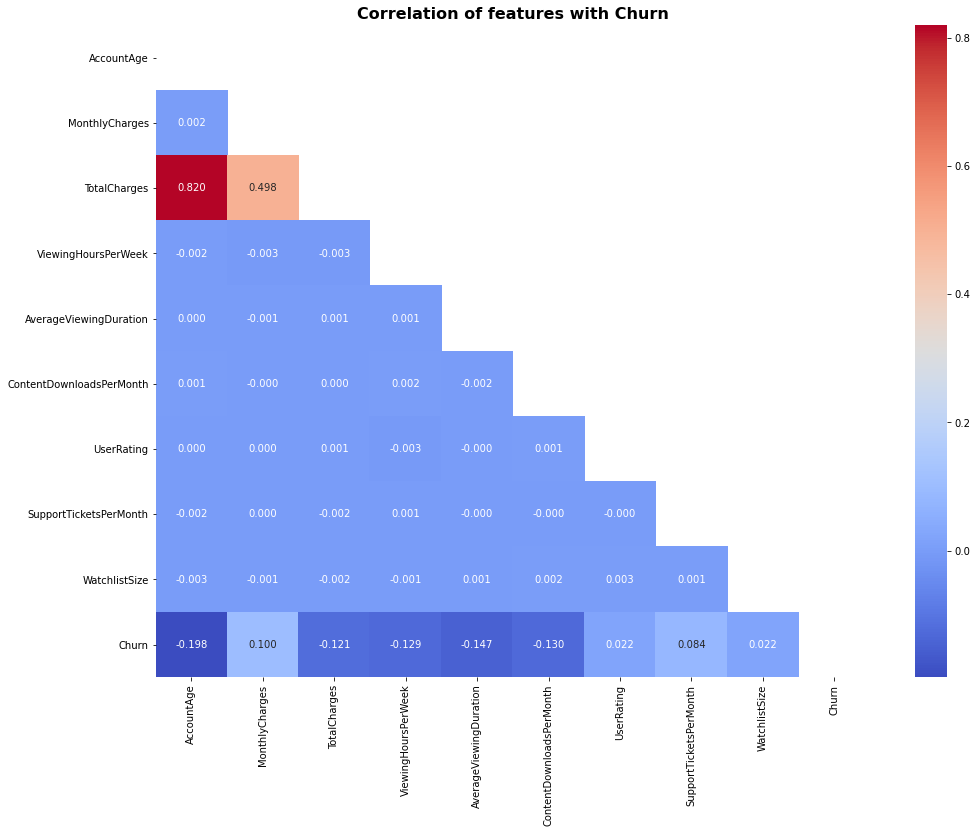

In [6]:
def plot_correlation(df, figsize=(16,12)):
  plt.figure(figsize=figsize)
  sns.heatmap(df.corr(), cmap='coolwarm', annot=True, fmt='.3f', mask=np.triu(df.corr()))
  plt.title('Correlation of features with Churn', fontdict=({'size': 16, 'fontweight': 'bold'}))
  plt.show()


plot_correlation(train_df)

In [7]:
train_df.select_dtypes(include=['float64', 'int']).head(10)

,AccountAge,MonthlyCharges,TotalCharges,ViewingHoursPerWeek,AverageViewingDuration,ContentDownloadsPerMonth,UserRating,SupportTicketsPerMonth,WatchlistSize,Churn
0,20,11.055215,221.104302,36.758104,63.531377,10,2.176498,4,3,0
1,57,5.175208,294.986882,32.450568,25.725595,18,3.478632,8,23,0
2,73,12.106657,883.785952,7.395160,57.364061,23,4.238824,6,1,0
3,32,7.263743,232.439774,27.960389,131.537507,30,4.276013,2,24,0
4,57,16.953078,966.325422,20.083397,45.356653,20,3.616170,4,0,0
5,113,7.295744,824.419081,21.678290,97.095746,35,3.721134,8,2,0
6,38,12.340675,468.945639,36.512761,81.782993,28,4.090868,9,20,0
7,25,7.247550,181.188753,16.355816,154.521682,10,3.410221,2,22,0
8,26,19.803233,514.884050,8.202929,94.375211,28,2.679986,0,5,1
9,14,18.842934,263.801080,38.560694,122.012890,0,2.993441,0,18,0


### Feature Engineering

In [8]:
def engineer_features(df_raw):
    df = df_raw.copy()
    df['MonthlyChargePerMovie'] = df['MonthlyCharges'] / (df['WatchlistSize'] + 1e-5)
    df['WatchListPerMonth'] = df['WatchlistSize'] / df['AccountAge']
    df.drop(['PaymentMethod', 'DeviceRegistered', 'TotalCharges'], axis=1, inplace=True)
    return df


duplicate train and test, reset index and encode categorical features

In [9]:
# make copies of dataframes
train = engineer_features(train_df)
test = engineer_features(test_df)
print(train.shape)

# Reset index to `CustomerID`
train.set_index(['CustomerID'], inplace=True)
test.set_index(['CustomerID'], inplace=True)


# encode categorical features
def encode_df(df, name):
    remnant_categoricals = []
    print(f'\nWhat the {name} categorical features contain\n=====================================\n')

    for feature in df.select_dtypes(include='object'):
        check = sorted(df[feature].value_counts().index)
        print(f'{feature}: {check}')
        print()
        if check[0] == 'No':
            df[feature] = df[feature].map({'No': 0, 'Yes': 1}).astype('int')
        elif check[0] == 'Female':
            df[feature] = df[feature].map({'Female': 0, 'Male': 1}).astype('int')
        elif  check[0] == 'Basic':
            df[feature] = df[feature].map({'Basic': 0, 'Standard':1, 'Premium': 2}).astype('int')
        elif  check[0] == 'Both':
            df[feature] = df[feature].map({'Movies': 0, 'TV Shows':1, 'Both': 2}).astype('int')
        else:
            remnant_categoricals.append(feature)

    remnant_df = pd.get_dummies(df[remnant_categoricals], drop_first=True)

    assert len(df.index) == len(remnant_df.index), 'two dataframes are different. Check again'

    df.drop(remnant_categoricals, axis=1, inplace=True)

    return pd.concat([df, remnant_df], axis=1)




train = encode_df(train, 'train')
print(train.shape)
test = encode_df(test, 'test')

(243787, 20)

What the train categorical features contain

SubscriptionType: ['Basic', 'Premium', 'Standard']

PaperlessBilling: ['No', 'Yes']

ContentType: ['Both', 'Movies', 'TV Shows']

MultiDeviceAccess: ['No', 'Yes']

GenrePreference: ['Action', 'Comedy', 'Drama', 'Fantasy', 'Sci-Fi']

Gender: ['Female', 'Male']

ParentalControl: ['No', 'Yes']

SubtitlesEnabled: ['No', 'Yes']

(243787, 22)

What the test categorical features contain

SubscriptionType: ['Basic', 'Premium', 'Standard']

PaperlessBilling: ['No', 'Yes']

ContentType: ['Both', 'Movies', 'TV Shows']

MultiDeviceAccess: ['No', 'Yes']

GenrePreference: ['Action', 'Comedy', 'Drama', 'Fantasy', 'Sci-Fi']

Gender: ['Female', 'Male']

ParentalControl: ['No', 'Yes']

SubtitlesEnabled: ['No', 'Yes']



Make features and target

In [10]:
target = train['Churn']
features = train.drop(['Churn'], axis=1)

# Ensure training and testing dataset have same columns
assert features.shape[1] == test.shape[1], f'columns must be {len(test.columns)}'


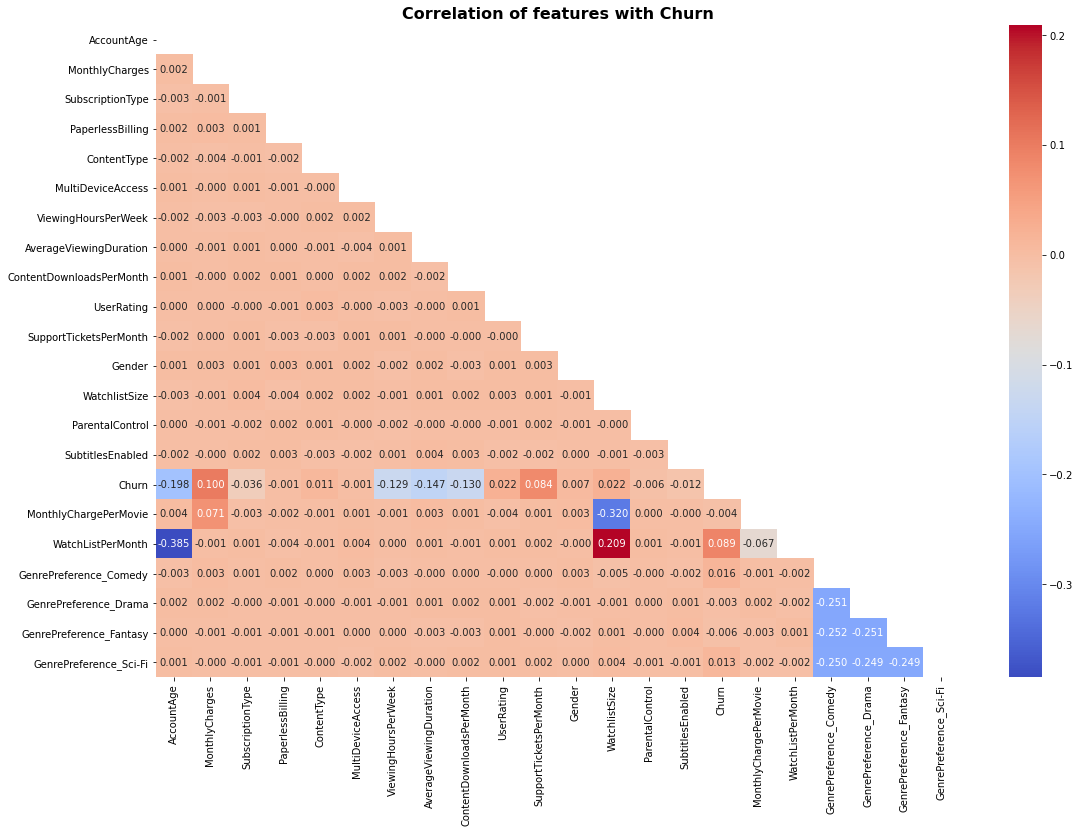

In [11]:
plot_correlation(train, figsize=(18,12))

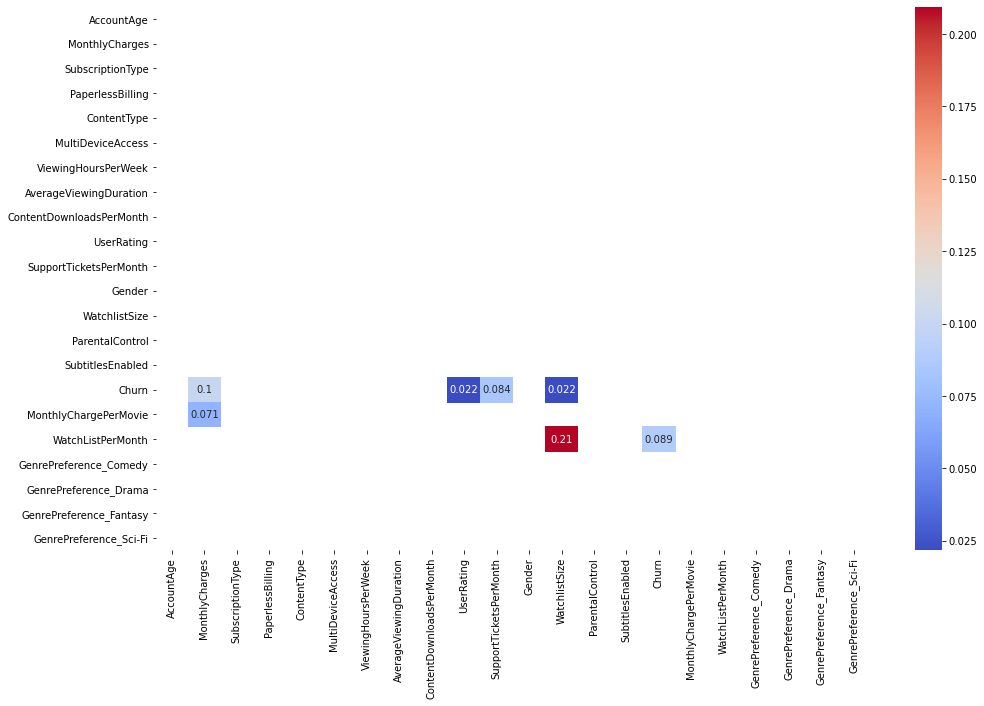

In [12]:
plt.figure(figsize=(16, 10))
sns.heatmap(train.corr()[train.corr() >= 0.02], cmap='coolwarm', mask=np.triu(train.corr()), annot=True);

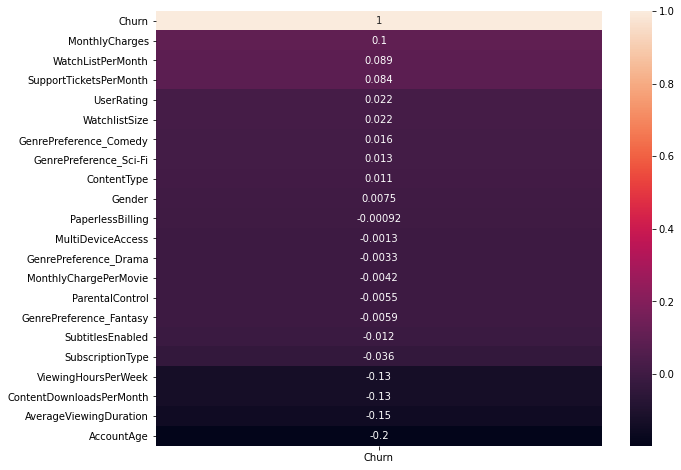

In [13]:
plt.figure(figsize=(10, 8))
sns.heatmap(train.corr()['Churn'].sort_values(ascending=False).to_frame(), annot=True);

From the correlation map above, of all features, it seems `MonthlyCharges` feature has the highest impact on the `churn` status of a customer

#### Checking for target inbalancing

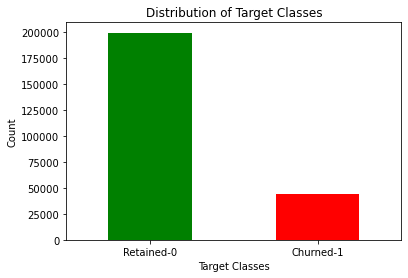

In [14]:
def show_imbalance(df):
    ax = df.value_counts().plot(kind='bar', rot=0, color=['g', 'r'],)
    plt.xticks(ticks=[0, 1], labels=['Retained-0', 'Churned-1'])
    ax.set(title='Distribution of Target Classes',
          xlabel='Target Classes',
          ylabel='Count')
    plt.show()

show_imbalance(target)

Now let's resample this

In [3]:
import imblearn.under_sampling as us

dir(us)

['AllKNN',
 'ClusterCentroids',
 'CondensedNearestNeighbour',
 'EditedNearestNeighbours',
 'InstanceHardnessThreshold',
 'NearMiss',
 'NeighbourhoodCleaningRule',
 'OneSidedSelection',
 'RandomUnderSampler',
 'RepeatedEditedNearestNeighbours',
 'TomekLinks',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_prototype_generation',
 '_prototype_selection',
 'base']

In [15]:
def resample(X, y, oversample=True):
    if oversample:
        oversampler = SMOTE(sampling_strategy='auto')
        X_res, y_res = oversampler.fit_resample(X, y)
    else:
        undersampler = RandomUnderSampler()
        X_res, y_res = undersampler.fit_resample(X, y)
    return (X_res, y_res)

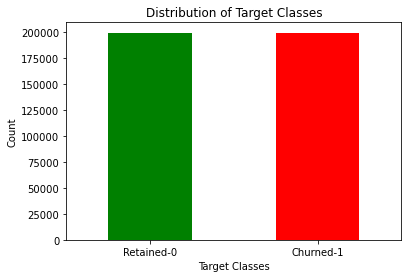

In [16]:
features, target = resample(features, target)

show_imbalance(target)

In [17]:
print(features.shape)

(399210, 21)


In [18]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

total_samples = 120

majority_class = np.zeros(int(total_samples * 0.85)).astype(int)
minority_class = np.ones(int(total_samples * .15)).astype(int)

y_train = np.concatenate([majority_class, minority_class])

weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

class_weights = dict(enumerate(weights))
class_weights

{0: 0.5882352941176471, 1: 3.3333333333333335}

In [16]:
y_train

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

#### Train and  Validation splits

In [18]:
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, stratify=target, random_state=42)

print(f'X_train shape: {X_train.shape} \nX_val shape: {X_val.shape} \ny_train shape: {y_train.shape} \ny_val shape: {y_val.shape}')

X_train shape: (319368, 21) 
X_val shape: (79842, 21) 
y_train shape: (319368,) 
y_val shape: (79842,)


#### Normilise all features with `MinMaxScaler()`

In [19]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

### Model training

With all preprocesing and exploration done, it's time to train models. There will be hyperparameters tuning.

In [20]:
import time

def train_classifier(classifier):
  classifier.fit(X_train, y_train)
  pred = classifier.predict(X_val)
  roc_auc = roc_auc_score(y_val, pred)
  print(f'\nestimator: {classifier.__class__.__name__} \nroc auc score: {roc_auc:.4f}')

  return pred, roc_auc

classifiers = {'rfc': RandomForestClassifier(random_state=random_state),
               'lr': LogisticRegression(random_state=random_state),
               'xgbc': XGBClassifier(random_state=random_state),
               'tree': DecisionTreeClassifier(random_state=random_state),
               'dummy': DummyClassifier()
               }

roc_scores = {classifiers[name]: None for name in classifiers.keys()}

for name in classifiers.keys():
    print(f'[INFO]: modelling {name} for baseline performance...', end='')
    start_time = time.time()
    pred, roc_scores[name] = train_classifier(classifiers[name])
    print(f'modelling time: {time.time() - start_time:.2f}s\n')
          

[INFO]: modelling rfc for baseline performance...
estimator: RandomForestClassifier 
roc auc score: 0.8507
modelling time: 91.95s

[INFO]: modelling lr for baseline performance...
estimator: LogisticRegression 
roc auc score: 0.8000
modelling time: 9.47s

[INFO]: modelling xgbc for baseline performance...
estimator: XGBClassifier 
roc auc score: 0.8194
modelling time: 72.90s

[INFO]: modelling tree for baseline performance...
estimator: DecisionTreeClassifier 
roc auc score: 0.7645
modelling time: 6.28s

[INFO]: modelling dummy for baseline performance...
estimator: DummyClassifier 
roc auc score: 0.5000
modelling time: 0.03s



#### Fine-tuning with tree parameters

In [21]:
rfc = RandomForestClassifier(random_state=random_state)

rfc_params = {
              'n_estimators': [100, 120, 150],
              'criterion': ["gini", "entropy"],
              'min_samples_leaf': [1, 2],
              'min_samples_split': [2, 4 ]
            }


rfc = RandomForestClassifier()

grid = GridSearchCV(rfc, rfc_params, scoring=make_scorer(roc_auc_score), cv=3)
print(f'tuning rfc best parameters...')
start_time =  time.time()
grid.fit(X_train, y_train)
print(f'total tuning time: {time.time() - start_time:.2f}')
rfc_best_parameters = grid.best_params_
print(rfc_best_parameters)

print(f'modelling tree with best parameters...')
start_time = time.time()
rfc = RandomForestClassifier(**rfc_best_parameters)
print(f'total modelling time: {time.time() - start_time:.2f}')

rfc_pred, rfc_roc_auc = train_classifier(rfc)

tuning rfc best parameters...
total tuning time: 5775.35
{'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
modelling tree with best parameters...
total modelling time: 0.00

estimator: RandomForestClassifier 
roc auc score: 0.8519


In [22]:
# for est in np.linspace(0, 2, 20):
#     rfc = RandomForestClassifier(n_estimators=100, random_state=42, ccp_alpha=est)
#     rfc.fit(X_train, y_train)
#     pred = rfc.predict(X_val)
#     print(roc_auc_score(y_val, pred), est)


## Make predictions (required)

Remember you should create a dataframe named `prediction_df` with exactly 104,480 entries plus a header row attempting to predict the likelihood of churn for subscriptions in `test_df`. Your submission will throw an error if you have extra columns (beyond `CustomerID` and `predicted_probaility`) or extra rows.

The file should have exactly 2 columns:
`CustomerID` (sorted in any order)
`predicted_probability` (contains your numeric predicted probabilities between 0 and 1, e.g. from `estimator.predict_proba(X, y)[:, 1]`)

The naming convention of the dataframe and columns are critical for our autograding, so please make sure to use the exact naming conventions of `prediction_df` with column names `CustomerID` and `predicted_probability`!

### Example prediction submission:

The code below is a very naive prediction method that simply predicts churn using a Dummy Classifier. This is used as just an example showing the submission format required. Please change/alter/delete this code below and create your own improved prediction methods for generating `prediction_df`.

**PLEASE CHANGE CODE BELOW TO IMPLEMENT YOUR OWN PREDICTIONS**

In [1]:
### PLEASE CHANGE THIS CODE TO IMPLEMENT YOUR OWN PREDICTIONS
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTEN

SyntaxError: invalid syntax (2318739837.py, line 2)

In [24]:
roc_auc_score(y_val, rfc_pred)

0.8518574184013427

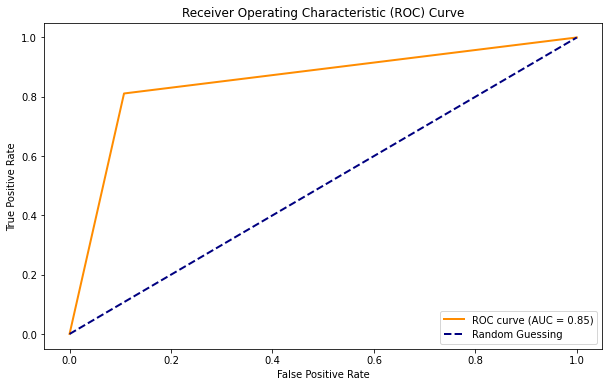

In [39]:
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_val, rfc_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [26]:
predicted_probability = rfc.predict(test)

In [40]:
### PLEASE CHANGE THIS CODE TO IMPLEMENT YOUR OWN PREDICTIONS

# Combine predictions with label column into a dataframe
prediction_df = pd.DataFrame({'CustomerID': test.index,
                             'predicted_probability': predicted_probability})

In [41]:
### PLEASE CHANGE THIS CODE TO IMPLEMENT YOUR OWN PREDICTIONS

# View our 'prediction_df' dataframe as required for submission.
# Ensure it should contain 104,480 rows and 2 columns 'CustomerID' and 'predicted_probaility'
print(prediction_df.shape)
prediction_df.head(10)

(104480, 2)


,CustomerID,predicted_probability
0,O1W6BHP6RM,0
1,LFR4X92X8H,0
2,QM5GBIYODA,0
3,D9RXTK2K9F,0
4,ENTCCHR1LR,0
5,7A88BB5IO6,0
6,70OMW9XEWR,0
7,EL1RMFMPYL,0
8,4IA2QPT6ZK,0
9,AEDCWHSJDN,0
